In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from bliss.encoders.detection import DetectionEncoder
from bliss.encoders.layers import ConcatBackgroundTransform

import matplotlib.pyplot as plt 
import torch
from astropy.table import Table
from bliss.datasets.table_utils import column_to_tensor

from bliss.datasets.table_utils import column_to_tensor
from astropy.table import Table
from bliss.datasets.lsst import get_default_lsst_psf, get_default_lsst_background
from bliss.datasets.background import add_noise_and_background


from einops import rearrange

# dataset
from bliss.datasets.galsim_blends import generate_dataset, SavedGalsimBlends, parse_dataset



In [ ]:
!echo $CUDA_VISIBLE_DEVICES

5


# Create SNR vs mag diagram for stars

In [ ]:
import bliss
from bliss.datasets.galsim_blends import _render_one_star
from bliss.datasets.lsst import convert_mag_to_flux, get_default_lsst_psf, get_default_lsst_background
from case_studies.galsim_galaxies.get_testing_datasets import _get_snr
import numpy as np 
import torch

bg =get_default_lsst_background()
bg = torch.full((1, 1, 100, 100), bg)

mags = torch.from_numpy(np.arange(14, 26.1, 0.1))
fluxes = convert_mag_to_flux(mags)
stars = [_render_one_star(get_default_lsst_psf(), f, 100) for f in fluxes]
snrs = [_get_snr(star.unsqueeze(0), bg) for star in stars]
snrs = np.array(snrs).reshape(-1)

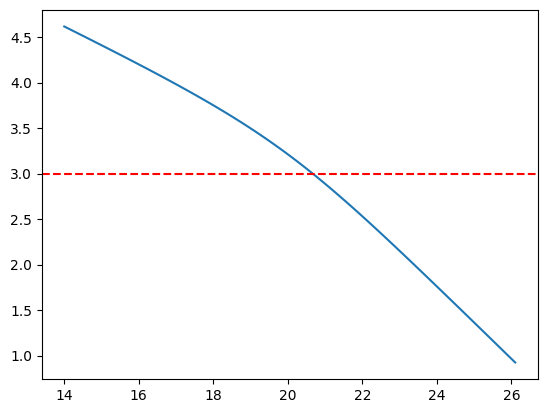

In [ ]:
plt.plot(mags, np.log10(snrs))
plt.axhline(3, color='r', linestyle='--')

In [ ]:
snrs.shape

(122, 1)

In [ ]:
snrs[66], mags[66]

(1051.2507, tensor(20.6000, dtype=torch.float64))

In [ ]:
np.argwhere(snrs < 1000)

array([[ 67],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
       [ 72],
       [ 73],
       [ 74],
       [ 75],
       [ 76],
       [ 77],
       [ 78],
       [ 79],
       [ 80],
       [ 81],
       [ 82],
       [ 83],
       [ 84],
       [ 85],
       [ 86],
       [ 87],
       [ 88],
       [ 89],
       [ 90],
       [ 91],
       [ 92],
       [ 93],
       [ 94],
       [ 95],
       [ 96],
       [ 97],
       [ 98],
       [ 99],
       [100],
       [101],
       [102],
       [103],
       [104],
       [105],
       [106],
       [107],
       [108],
       [109],
       [110],
       [111],
       [112],
       [113],
       [114],
       [115],
       [116],
       [117],
       [118],
       [119],
       [120],
       [121]])

## Check dataset with stars

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()



(array([9.400e+01, 7.060e+02, 1.840e+03, 2.180e+03, 2.057e+03, 1.982e+03,
        1.757e+03, 1.539e+03, 1.544e+03, 1.275e+03, 1.171e+03, 1.023e+03,
        7.860e+02, 6.440e+02, 4.840e+02, 3.820e+02, 3.400e+02, 2.270e+02,
        1.870e+02, 1.410e+02, 1.060e+02, 6.800e+01, 4.100e+01, 3.600e+01,
        1.500e+01, 2.200e+01, 9.000e+00, 6.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 1.79721344,  2.39981341,  3.00241327,  3.60501313,  4.20761299,
         4.81021309,  5.41281271,  6.01541281,  6.61801243,  7.22061253,
         7.82321215,  8.42581177,  9.02841187,  9.63101196, 10.23361206,
        10.83621216, 11.4388113 , 12.0414114 , 12.6440115 , 13.2466116 ,
        13.84921074, 14.45181084, 15.05441093, 15.65701103, 16.25961113,
        16.86221123, 17.46481133, 18.06740952, 18.67000961, 19.27260971,
        19.87520981, 20.47780991]),
 <BarContainer object of 31 artists>)

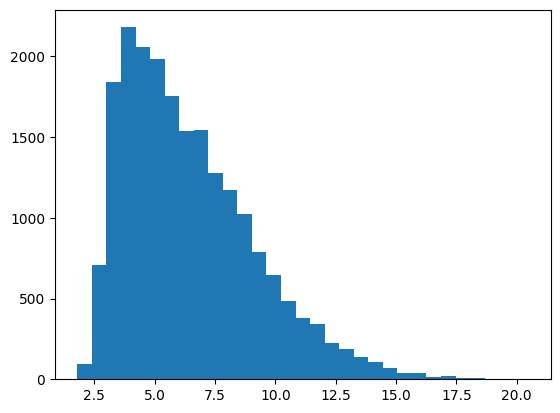

In [ ]:
n_samples = 5000

dataset = generate_dataset(n_samples, catsim_table, all_star_mags, psf, max_n_sources=10, add_galaxies_in_padding=True, galaxy_density=100, star_density=100)

In [ ]:
dataset.keys()

dict_keys(['images', 'background', 'noiseless', 'individuals', 'star_fluxes', 'star_bools', 'fluxes', 'galaxy_params', 'n_sources', 'galaxy_bools', 'plocs'])

In [ ]:
gfluxes = dataset['galaxy_params'][:, :, -1].flatten()
gfluxes = gfluxes[gfluxes > 0 ]


sfluxes = dataset['star_fluxes'][:, :, 0].flatten()
sfluxes = sfluxes[sfluxes > 0 ]

gfluxes.shape, sfluxes.shape

(torch.Size([9041]), torch.Size([8855]))

(array([0.        , 0.        , 0.        , 0.00406714, 0.01111689,
        0.06100717, 0.14587492, 0.17244732, 0.18627522, 0.15753407,
        0.16295729, 0.15021321, 0.13665606, 0.13719865, 0.12065862,
        0.13150434, 0.09896718, 0.09923855, 0.09435775, 0.08242746,
        0.07103962, 0.06398988, 0.05178831, 0.04067145, 0.04175602,
        0.03714659, 0.02413172, 0.02413183, 0.01681086, 0.01653972,
        0.01491286]),
 array([ 6.99485016,  7.4194026 ,  7.84395552,  8.26850796,  8.69306087,
         9.11761284,  9.54216576,  9.96671867, 10.39127064, 10.81582355,
        11.24037647, 11.66492844, 12.08948135, 12.51403427, 12.93858624,
        13.36313915, 13.78769207, 14.21224499, 14.63679695, 15.06134987,
        15.48590279, 15.91045475, 16.33500671, 16.75955963, 17.18411255,
        17.60866547, 18.03321838, 18.4577713 , 18.88232231, 19.30687523,
        19.73142815, 20.15598106]),
 [<matplotlib.patches.Polygon at 0x7f884866a200>])

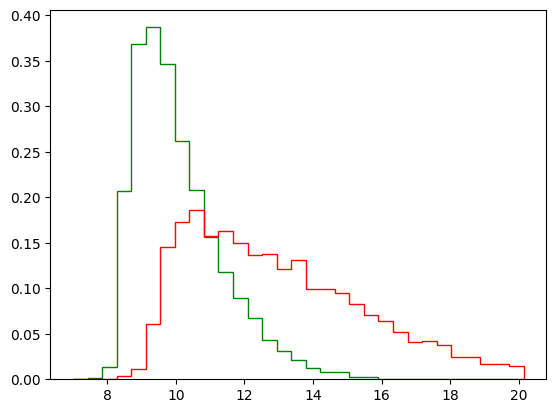

In [ ]:
_, bins, _ = plt.hist(gfluxes.log().numpy(), bins=31, color='g', histtype='step', density=True)
plt.hist(sfluxes.log().numpy(), bins=bins, color='r', histtype='step', density=True)

# fluxes = 10**(0.4 * (30 - all_star_mags))
# plt.hist(fluxes.log(), bins=bins, density=True, color='b', histtype='step')


In [ ]:
all_star_mags.shape, catsim_table['i_ab'].shape

(torch.Size([20667]), (858502,))

(array([  75.,  111.,  122.,  151.,  175.,  236.,  283.,  310.,  386.,
         511.,  534.,  670.,  815.,  899.,  968., 1117., 1171., 1187.,
        1345., 1416., 1574., 1620., 1677., 1567., 1142.,  327.,   72.,
           3.,    0.,    0.,    0.]),
 array([14.32465935, 14.8299779 , 15.33529645, 15.840615  , 16.34593354,
        16.85125209, 17.35657064, 17.86188919, 18.36720774, 18.87252629,
        19.37784484, 19.88316339, 20.38848194, 20.89380049, 21.39911904,
        21.90443759, 22.40975614, 22.91507469, 23.42039324, 23.92571179,
        24.43103033, 24.93634888, 25.44166743, 25.94698598, 26.45230453,
        26.95762308, 27.46294163, 27.96826018, 28.47357873, 28.97889728,
        29.48421583, 29.98953438]),
 [<matplotlib.patches.Polygon at 0x7f1842af44c0>])

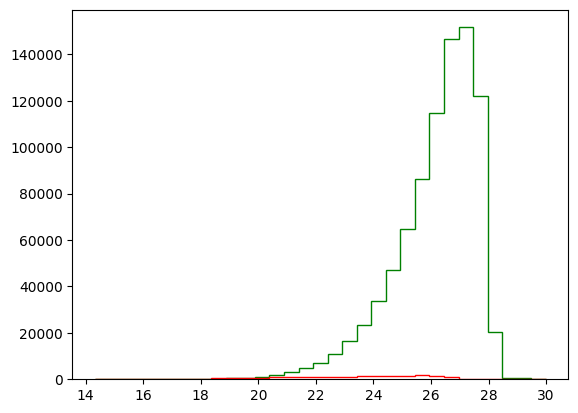

In [ ]:
_, bins, _ = plt.hist(catsim_table['i_ab'], bins=31, color='g', histtype='step')
plt.hist(all_star_mags, bins=bins, color='r', histtype='step')

## Fluxes with Galsim

In [ ]:
import galsim 

bandpass_i_file = galsim.meta_data.share_dir + "/bandpasses/LSST_i.dat"
bandpass_i_file

'/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/galsim/share/bandpasses/LSST_i.dat'

In [ ]:
from galsim import Bandpass

bp = Bandpass(bandpass_i_file, wave_type='nm')

In [ ]:
bp_ab = bp.withZeropoint("AB")

In [ ]:
import math
diam = 8.36
star_fluxes = 10**((all_star_mags - bp_ab.zeropoint) / -2.5 ) * 5520 * math.pi * (diam/2 * 100)**2 * 0.39257227

galaxy_fluxes = 10**((catsim_table['i_ab'] - bp_ab.zeropoint) / -2.5 ) * 5520 * math.pi * (diam/2 * 100)**2 * 0.39257227

(array([2.26979914e-03, 6.05134771e-01, 6.27535327e-01, 2.49612841e-01,
        8.24860994e-02, 2.27240169e-02, 5.01549392e-03, 9.62945089e-04,
        1.56153258e-04, 2.97434777e-05]),
 array([2.67898667, 3.30558167, 3.93217667, 4.55877168, 5.18536668,
        5.81196168, 6.43855668, 7.06515168, 7.69174668, 8.31834168,
        8.94493668]),
 [<matplotlib.patches.Polygon at 0x7f18437207f0>])

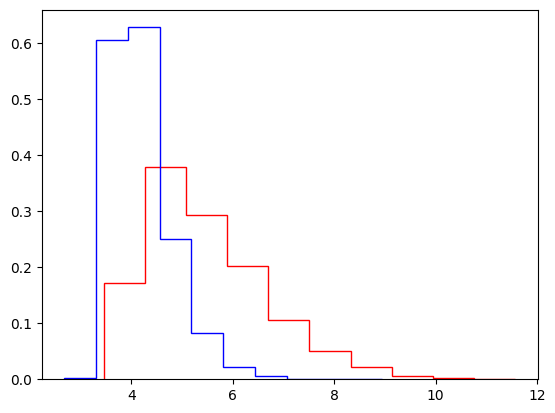

In [ ]:
import numpy as np
_, bins, _ = plt.hist(np.log10(star_fluxes), color='r', histtype="step", density=True)
plt.hist(np.log10(galaxy_fluxes), color='b', histtype="step", density=True)



In [ ]:
catsim_table['i_ab'].min()

14.3246593475

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01834772e-05, 1.30930422e-05, 3.20052142e-05, 9.74703104e-05,
        2.42948957e-04, 6.09553135e-04, 1.41550500e-03, 3.16996726e-03,
        7.22736777e-03, 1.46292752e-02, 2.84700593e-02, 5.21554674e-02,
        9.14722494e-02, 1.53673217e-01, 2.43184060e-01, 3.45920035e-01,
        2.90285497e-01]),
 array([ 7.7665    ,  8.57778835,  9.38907623, 10.20036411, 11.01165199,
        11.82293987, 12.63422775, 13.44551563, 14.25680447, 15.06809235,
        15.87938023, 16.69066811, 17.50195694, 18.31324387, 19.1245327 ,
        19.93581963, 20.74710846, 21.55839539, 22.36968422, 23.18097305,
        23.99225998, 24.80354881, 25.61483574, 26.42612457, 27.2374115 ,
        28.04870033]),
 [<matplotlib.patches.Polygon at 0x7f184285fac0>])

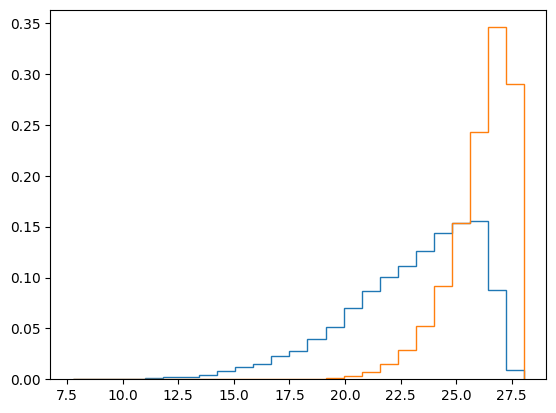

In [ ]:
_, bins, _ = plt.hist(all_star_mags, bins=25, density=True, histtype='step')
plt.hist(catsim_table['i_ab'], bins=bins, density=True, histtype='step')

In [ ]:
np.quantile(catsim_table['i_ab'], 0.001)

19.359883264579597